# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0
!pwd
!cp vision/references/detection/utils.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/coco_utils.py .

fatal: destination path 'vision' already exists and is not an empty directory.
error: pathspec 'v0.3.0' did not match any file(s) known to git.
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [2]:
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model



In [6]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
import os
if False:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)#.cuda()
    dataset = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed',transforms=get_transform(train=True))
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

In [8]:
# For Testing Training
if False:
    images,targets = next(iter(data_loader))
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    output = model(images,targets)   # Returns losses and detections
    # For inference
    model.eval()
    x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
    predictions = model(x)           # Returns predictions
    predictions


In [9]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(int(len(dataset))).tolist()
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:4])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-2:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")
3

Epoch: [0]  [0/2]  eta: 0:00:06  lr: 0.005000  loss: 4.4573 (4.4573)  loss_classifier: 0.6102 (0.6102)  loss_box_reg: 0.1364 (0.1364)  loss_mask: 3.7057 (3.7057)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 3.4002  data: 0.1181  max mem: 3054
Epoch: [0]  [1/2]  eta: 0:00:02  lr: 0.005000  loss: 3.2013 (3.8293)  loss_classifier: 0.6102 (0.6305)  loss_box_reg: 0.1364 (0.1831)  loss_mask: 2.2829 (2.9943)  loss_objectness: 0.0029 (0.0156)  loss_rpn_box_reg: 0.0020 (0.0058)  time: 2.6397  data: 0.0593  max mem: 3054
Epoch: [0] Total time: 0:00:05 (2.6488 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:01  model_time: 0.5720 (0.5720)  evaluator_time: 0.0571 (0.0571)  time: 0.7208  data: 0.0907  max mem: 3054
Test:  [1/2]  eta: 0:00:00  model_time: 0.5182 (0.5451)  evaluator_time: 0.0553 (0.0562)  time: 0.6487  data: 0.0455  max mem: 3054
Test: Total time: 0:00:01 (0.6599 s / it)
Averaged stats: model_time: 0.5182 (0.5451)  evaluator_time: 0.055

3

In [10]:
# pick one image from the test set
img, img2 = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

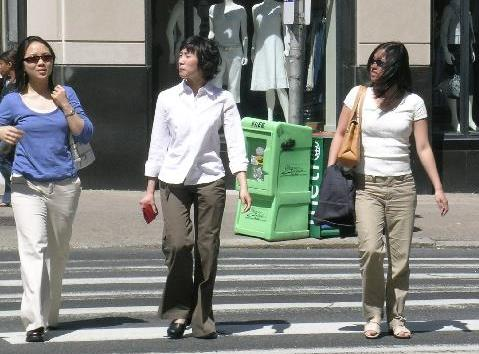

In [19]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
torch.Size([3, 354, 479])
0
1
2


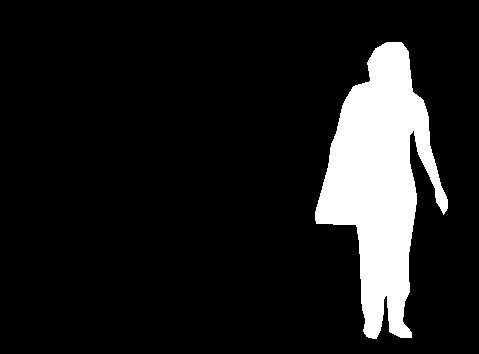

In [21]:
print(img2.keys())
print(img2['masks'].shape)
for i in range(img2['masks'].shape[0]):
    print (i)
Image.fromarray(img2['masks'][2].mul(255).byte().numpy())

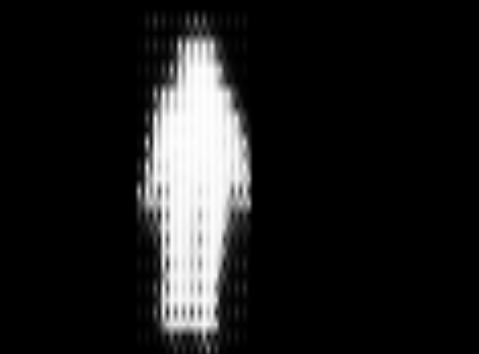

In [13]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())